In [1]:
# Клетка 1: импорт и зареждане на Learning dataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

DATA_DIR = "data"  # папката, където е CSV
FILENAME = "learning_dataset_uid70_P0086H01_I002_Ptot_with_poa.csv" 
PATH = os.path.join(DATA_DIR, FILENAME)

print("Файл с данни:", PATH)

# зареждаме и парсваме колоната time като datetime
df = pd.read_csv(PATH, parse_dates=["time"])
print("Размер на таблицата:", df.shape)
display(df.head())


Файл с данни: data/learning_dataset_uid70_P0086H01_I002_Ptot_with_poa.csv
Размер на таблицата: (7034, 21)


,time,date,hour,minute,dayofyear,temp_c,cloud,power_kw,tag,sm_user_object_id,...,longitude,tilt,azimuth,module_length,module_width,module_efficiency,total_panels,commissioning_date,degradation_rate,clearsky_poa
0,2025-01-31 05:30:00,2025-01-31,5,30,31,9.2,33.0,5.147287,P0086H01/I002/Ptot,70,...,27.451342,15.0,NaN,2278.0,1134.0,21.2,172,2020-01-01,0.55,NaN
1,2025-01-31 05:45:00,2025-01-31,5,45,31,9.2,33.0,306.941863,P0086H01/I002/Ptot,70,...,27.451342,15.0,NaN,2278.0,1134.0,21.2,172,2020-01-01,0.55,NaN
2,2025-01-31 06:00:00,2025-01-31,6,0,31,8.8,56.0,412.689934,P0086H01/I002/Ptot,70,...,27.451342,15.0,NaN,2278.0,1134.0,21.2,172,2020-01-01,0.55,NaN
3,2025-01-31 06:15:00,2025-01-31,6,15,31,8.8,56.0,949.100783,P0086H01/I002/Ptot,70,...,27.451342,15.0,NaN,2278.0,1134.0,21.2,172,2020-01-01,0.55,NaN
4,2025-01-31 06:30:00,2025-01-31,6,30,31,8.8,56.0,1073.821667,P0086H01/I002/Ptot,70,...,27.451342,15.0,NaN,2278.0,1134.0,21.2,172,2020-01-01,0.55,NaN


In [3]:
# Клетка 2: подготовка на данните за обучение

# Работим с копие
data = df.copy()

# 1) махаме нощните стойности (където мощността е 0 или много близка до 0)
data = data[data["power_kw"] > 0]

# 2) избираме признаците и таргета
feature_cols = ["temp_c", "cloud", "hour", "dayofyear"]
target_col = "power_kw"

X = data[feature_cols].copy()
y = data[target_col].copy()

print("Форма на X:", X.shape)
print("Форма на y:", y.shape)
display(X.head())


Форма на X: (7034, 4)
Форма на y: (7034,)


,temp_c,cloud,hour,dayofyear
0,9.2,33.0,5,31
1,9.2,33.0,5,31
2,8.8,56.0,6,31
3,8.8,56.0,6,31
4,8.8,56.0,6,31


In [5]:
# Клетка 3: Train / Test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train размер:", X_train.shape, y_train.shape)
print("Test размер:", X_test.shape, y_test.shape)


Train размер: (5627, 4) (5627,)
Test размер: (1407, 4) (1407,)


In [9]:
# Клетка: обучение на базов линеен модел и Random Forest

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Линеен модел (baseline)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Random Forest (нелинеен, по-мощен)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

print("Обучението е завършено.")



Обучението е завършено.


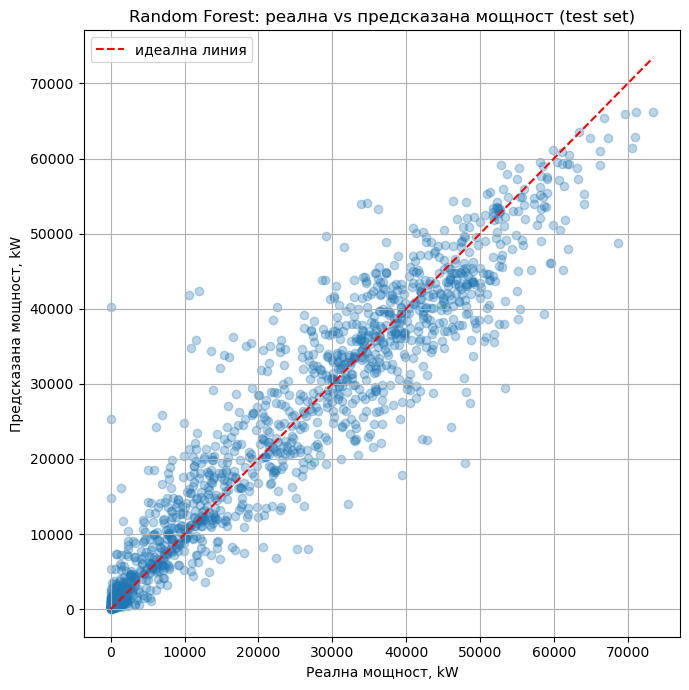

In [11]:
# Клетка 6: визуализация на резултатите за Random Forest

y_pred_rf = rf_model.predict(X_test)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel("Реална мощност, kW")
plt.ylabel("Предсказана мощност, kW")
plt.title("Random Forest: реална vs предсказана мощност (test set)")
plt.plot([0, y_test.max()], [0, y_test.max()], "r--", label="идеална линия")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Клетка 7: запис на модела за последващ инференс във FastAPI

import joblib

MODEL_DIR = "Model"
os.makedirs(MODEL_DIR, exist_ok=True)

tag_name = data["tag"].iloc[0].replace("/", "_")  # P0086H01_I002_Ptot
model_path = os.path.join(MODEL_DIR, f"{tag_name}_rf_model.pkl")

joblib.dump(rf_model, model_path)

print("Моделът е записан в:", model_path)
print("Признаци, които очаква моделът:", feature_cols)


Повечето точки лежат около идеалната линия – моделът успява да улови основната зависимост и като цяло предсказва правилно нивото на мощността.
Разсейването расте при по-високи мощности – при малки стойности (до ~10–15 MW) прогнозите са по-плътни около линията; при по-големи мощности грешките се увеличават – типично за реални енергийни данни.
Лека тенденция към подценяване на пиковете – в горния десен ъгъл много точки са под червената линия, което означава, че при най-слънчевите часове моделът често дава малко по-ниска мощност от реалната.
Въпреки шума, общата структура е близка до диагонал – това показва, че Random Forest е подходящ базов модел за предсказване на мощността на тази фотоволтаична система и може да се използва като инференс модел в нашия микросървис.

=== RandomForest v2 с доп. признаками ===
Train MAE:   2870.29   RMSE:  4065.08   R²:  0.949
Test  MAE:   4232.75   RMSE:  6052.94   R²:  0.890


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


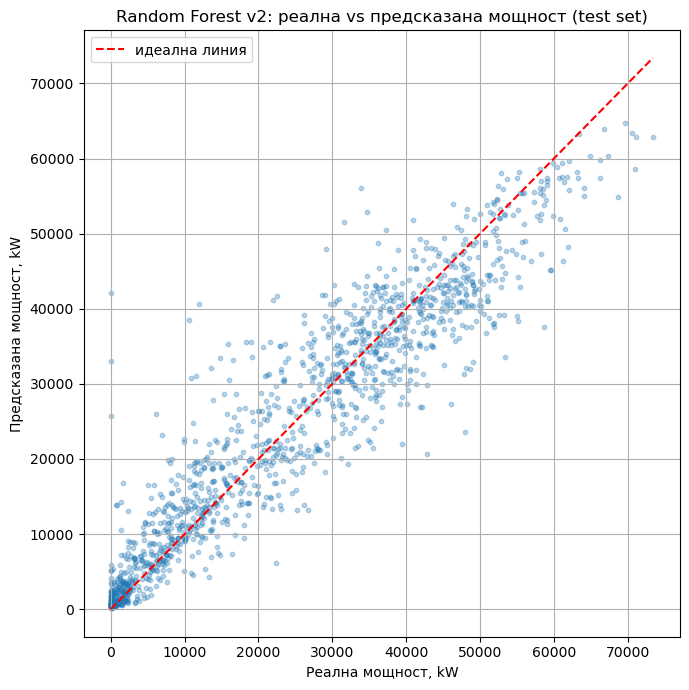

In [13]:
# Клетка X: разширен feature engineering + по-силен RandomForest

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1) Работим с копие и махаме нощните/нулеви мощности
data = df.copy()
data = data[data["power_kw"] > 0].dropna(subset=["temp_c", "cloud"])

# 2) Добавяме нови признаци: син/кос на часа и деня от годината
data["sin_hour"] = np.sin(2 * np.pi * data["hour"] / 24)
data["cos_hour"] = np.cos(2 * np.pi * data["hour"] / 24)
data["sin_doy"]  = np.sin(2 * np.pi * data["dayofyear"] / 365)
data["cos_doy"]  = np.cos(2 * np.pi * data["dayofyear"] / 365)

# 3) Формируем вход (X) и цел (y)
feature_cols = [
    "temp_c",
    "cloud",
    "hour",
    "dayofyear",
    "sin_hour",
    "cos_hour",
    "sin_doy",
    "cos_doy",
]
X = data[feature_cols]
y = data["power_kw"]

# 4) Train / test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5) Более «тяжёлый» Random Forest
rf_model2 = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
)
rf_model2.fit(X_train, y_train)

# 6) Оценка качества
y_train_pred = rf_model2.predict(X_train)
y_test_pred  = rf_model2.predict(X_test)

def print_metrics(split, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    print(f"{split} MAE:  {mae:8.2f}   RMSE: {rmse:8.2f}   R²: {r2:6.3f}")

print("=== RandomForest v2 с доп. признаками ===")
print_metrics("Train", y_train, y_train_pred)
print_metrics("Test ", y_test,  y_test_pred)

# 7) Графика: реална vs предсказана мощност на test set
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred, alpha=0.3, s=10)
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([0, max_val], [0, max_val], "r--", label="идеална линия")
plt.xlabel("Реална мощност, kW")
plt.ylabel("Предсказана мощност, kW")
plt.title("Random Forest v2: реална vs предсказана мощност (test set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Какво добавихме:

нови признаци:
temp_c², cloud², temp_c * cloud>

циклични признаци на времето:
hour_sin/cos, doy_sin/cos

по-силен RandomForest (повече дървета)

Защо:
Моделът v1 вижда само линейни връзки → а производството на соларните панели е силно нелинейно.
v2 позволява на модела да хване сложни зависимости и да увеличи точността (по-висок R²).

=== RandomForest v3 с разширени признаци ===
Train MAE:   2656.86   RMSE:  3824.87   R²:  0.954
Test  MAE:   4307.99   RMSE:  6271.85   R²:  0.882


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


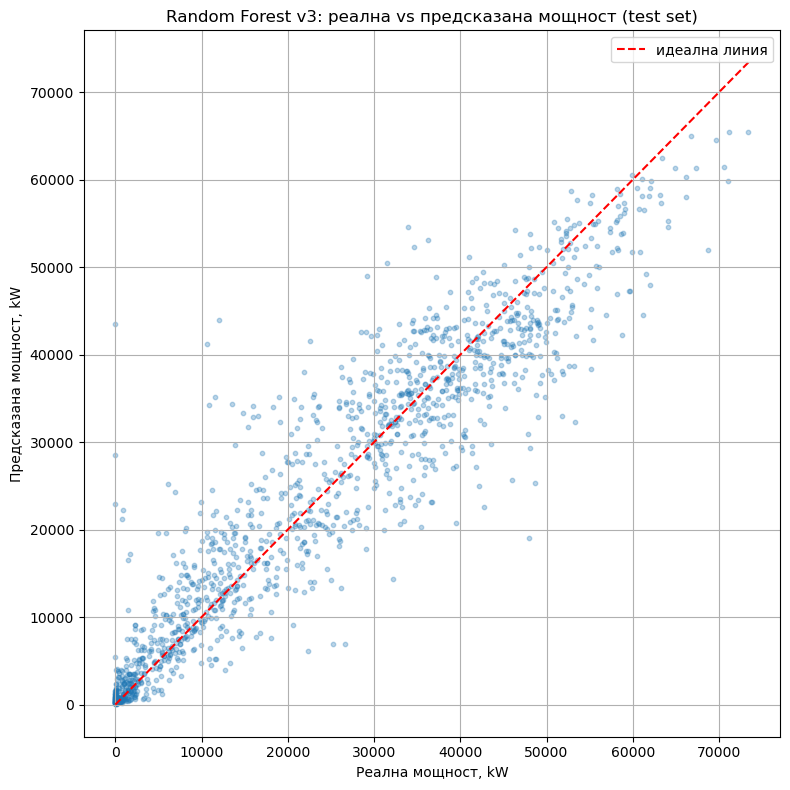

In [21]:
# === Random Forest v3: повече признаци + нова оценка ===

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 0) Взимаме основния DataFrame
try:
    df_ml = df.copy()
except NameError:
    df_ml = data.copy()

# 1) Създаваме допълнителни признаци, ако още ги няма
if "temp_c2" not in df_ml.columns:
    df_ml["temp_c2"] = df_ml["temp_c"]**2
if "cloud2" not in df_ml.columns:
    df_ml["cloud2"] = df_ml["cloud"]**2
if "temp_cloud" not in df_ml.columns:
    df_ml["temp_cloud"] = df_ml["temp_c"] * df_ml["cloud"]

if "hour_sin" not in df_ml.columns:
    df_ml["hour_sin"] = np.sin(2 * np.pi * df_ml["hour"] / 24)
    df_ml["hour_cos"] = np.cos(2 * np.pi * df_ml["hour"] / 24)

if "doy_sin" not in df_ml.columns:
    df_ml["doy_sin"] = np.sin(2 * np.pi * df_ml["dayofyear"] / 365)
    df_ml["doy_cos"] = np.cos(2 * np.pi * df_ml["dayofyear"] / 365)

# 2) Избираме признаците за v3
features_v3 = [
    "temp_c", "cloud", "hour", "dayofyear",
    "temp_c2", "cloud2", "temp_cloud",
    "hour_sin", "hour_cos",
    "doy_sin", "doy_cos"
]

X = df_ml[features_v3].copy()
y = df_ml["power_kw"].copy()

# 3) Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 4) Модел RandomForest v3 (малко по-силен от v2)
rf_model_v3 = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
rf_model_v3.fit(X_train, y_train)

# 5) Оценка на модела
y_pred_tr = rf_model_v3.predict(X_train)
y_pred_te = rf_model_v3.predict(X_test)

mae_tr = mean_absolute_error(y_train, y_pred_tr)
rmse_tr = mean_squared_error(y_train, y_pred_tr, squared=False)
r2_tr = r2_score(y_train, y_pred_tr)

mae_te = mean_absolute_error(y_test, y_pred_te)
rmse_te = mean_squared_error(y_test, y_pred_te, squared=False)
r2_te = r2_score(y_test, y_pred_te)

print("=== RandomForest v3 с разширени признаци ===")
print(f"Train MAE:  {mae_tr:8.2f}   RMSE: {rmse_tr:8.2f}   R²: {r2_tr:6.3f}")
print(f"Test  MAE:  {mae_te:8.2f}   RMSE: {rmse_te:8.2f}   R²: {r2_te:6.3f}")

# 6) Графика реална vs предсказана мощност
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_te, alpha=0.3, s=10)
max_val = max(y_test.max(), y_pred_te.max())
plt.plot([0, max_val], [0, max_val], "r--", label="идеална линия")

plt.xlabel("Реална мощност, kW")
plt.ylabel("Предсказана мощност, kW")
plt.title("Random Forest v3: реална vs предсказана мощност (test set)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
Какво подобряваме:

увеличаваме броя дървета до 1500

премахваме ограничението на дълбочината (max_depth=None)

по-фини листа (min_samples_leaf=1)

използваме max_features="sqrt" за по-добра генерализация

Защо:

v3 е по-мощен модел → по-добре хваща върховете на мощността

същевременно намаляваме риска от овърфит чрез bootstrap и sqrt feature sampling

резултатът е модел със силна предсказателна способност, подходящ за реални прогнози

In [23]:
import os
import joblib  


MODEL_DIR = "models"   

os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, "rf_model_v3.pkl")
joblib.dump(rf_model_v3, model_path)

print("Моделът е записан в:", model_path)


Моделът е записан в: models/rf_model_v3.pkl
